In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import os

In [2]:
DB_PATH = 'inventory.db' # SQLite file created in working directory
np.random.seed(42)

In [3]:
def init_db(db_path=DB_PATH, recreate=False):
    if recreate and os.path.exists(db_path):
        os.remove(db_path)
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    
    # Products table
    cur.execute('''
    CREATE TABLE IF NOT EXISTS products (
        product_id INTEGER PRIMARY KEY,
        name TEXT,
        category TEXT,
        current_stock INTEGER,
        reorder_level INTEGER
    )''')
    
    # Sales table
    cur.execute('''
    CREATE TABLE IF NOT EXISTS sales (
        sale_id INTEGER PRIMARY KEY AUTOINCREMENT,
        product_id INTEGER,
        quantity INTEGER,
        sale_date TEXT,
        FOREIGN KEY(product_id) REFERENCES products(product_id)
    )''')
    
    # Purchases table
    cur.execute('''
    CREATE TABLE IF NOT EXISTS purchases (
        purchase_id INTEGER PRIMARY KEY AUTOINCREMENT,
        product_id INTEGER,
        quantity INTEGER,
        purchase_date TEXT,
        FOREIGN KEY(product_id) REFERENCES products(product_id)
    )''')
    
    conn.commit()
    conn.close()


In [4]:
init_db(recreate=True)


In [5]:
def seed_products(db_path=DB_PATH):
    products = [
        (1, 'Widget A', 'Widgets', 500, 50),
        (2, 'Widget B', 'Widgets', 300, 40),
        (3, 'Gadget X', 'Gadgets', 200, 30),
    ]
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.executemany(
        'INSERT INTO products(product_id, name, category, current_stock, reorder_level) VALUES (?, ?, ?, ?, ?)',
        products
    )
    conn.commit()
    conn.close()

# Run this once to add the products
seed_products()

In [6]:
def add_or_update_product_interactive(db_path=DB_PATH):
    """
    Allows a user to interactively add a new product or update an existing one
    by entering its details, including safety stock.
    """
    print("\n--- Add or Update Product Details ---")
    try:
        name = input("Enter Product Name: ").strip()
        if not name:
            print("Product name cannot be empty. Aborting.")
            return

        category = input("Enter Category: ").strip()

        # Loop until a valid number is entered for current stock
        while True:
            try:
                current_stock = int(input("Enter Current Stock level: "))
                break
            except ValueError:
                print("Invalid input. Please enter a whole number for stock.")

        # Loop until a valid number is entered for safety stock
        while True:
            try:
                safety_stock = int(input("Enter Safety Stock (Reorder Level): "))
                break
            except ValueError:
                print("Invalid input. Please enter a whole number for safety stock.")

        # Loop until a valid number is entered for lead time
        while True:
            try:
                lead_time = int(input("Enter Supplier Lead Time (in days): "))
                break
            except ValueError:
                print("Invalid input. Please enter a whole number for lead time.")

        conn = sqlite3.connect(db_path)
        cur = conn.cursor()

        # Check if a product with this name already exists
        cur.execute("SELECT product_id FROM products WHERE name = ?", (name,))
        existing_product = cur.fetchone()

        if existing_product:
            # If it exists, confirm before updating
            product_id = existing_product[0]
            confirm = input(f"Product '{name}' already exists. Do you want to update it? (y/n): ").lower()
            if confirm == 'y':
                cur.execute("""
                    UPDATE products
                    SET category = ?, current_stock = ?, reorder_level = ?, supplier_lead_time_days = ?
                    WHERE product_id = ?
                """, (category, current_stock, safety_stock, lead_time, product_id))
                print(f"✅ Successfully updated product '{name}'.")
            else:
                print("Update cancelled.")
        else:
            # If it's a new product, insert it
            cur.execute("""
                INSERT INTO products (name, category, current_stock, reorder_level, supplier_lead_time_days)
                VALUES (?, ?, ?, ?, ?)
            """, (name, category, current_stock, safety_stock, lead_time))
            print(f"✅ Successfully added new product '{name}'.")

        conn.commit()
        conn.close()

    except Exception as e:
        print(f"An error occurred: {e}")

# --- Main Interaction Loop ---
# This loop allows you to add or update multiple products in a row.
while True:
    add_another = input("\nDo you want to add or update a product's stock details? (y/n): ").lower()
    if add_another == 'y':
        add_or_update_product_interactive()
    else:
        print("\nContinuing with the analysis...")
        break

# Display the final products table to verify the changes
print("\n--- Current Products in Database ---")
conn = sqlite3.connect(DB_PATH)
print(pd.read_sql_query("SELECT * FROM products", conn))
conn.close()


Do you want to add or update a product's stock details? (y/n):  n



Continuing with the analysis...

--- Current Products in Database ---
   product_id      name category  current_stock  reorder_level
0           1  Widget A  Widgets            500             50
1           2  Widget B  Widgets            300             40
2           3  Gadget X  Gadgets            200             30


In [7]:
def simulate_sales(days=365, db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    today = datetime.now().date()
    rows = []
    
    for d in range(days):
        date = (today - timedelta(days=days - d)).isoformat()
        
        # Simulated daily sales patterns with some seasonality + randomness
        q1 = max(0, int(5 + 2*np.sin(d/14.0) + np.random.poisson(2)))  # Widget A
        q2 = max(0, int(3 + 1.5*np.sin(d/21.0 + 1) + np.random.poisson(1)))  # Widget B
        q3 = max(0, int(2 + 1*np.sin(d/30.0 + 2) + np.random.poisson(1)))  # Gadget X
        
        rows.append((1, q1, date))
        rows.append((2, q2, date))
        rows.append((3, q3, date))
    
    cur.executemany(
        'INSERT INTO sales(product_id, quantity, sale_date) VALUES (?, ?, ?)', 
        rows
    )
    conn.commit()
    conn.close()

# Generate 1 year (365 days) of fake sales history
simulate_sales(days=365)


In [8]:
def get_current_stock(product_id, db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute('SELECT current_stock FROM products WHERE product_id=?', (product_id,))
    r = cur.fetchone()
    conn.close()
    if r:
        return int(r[0])
    return None


def record_sale(product_id, quantity, sale_date=None, db_path=DB_PATH):
    if sale_date is None:
        sale_date = datetime.now().isoformat()
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    
    # insert sale record
    cur.execute('INSERT INTO sales(product_id, quantity, sale_date) VALUES (?, ?, ?)',
                (product_id, quantity, sale_date))
    
    # update product stock
    cur.execute('UPDATE products SET current_stock = current_stock - ? WHERE product_id = ?',
                (quantity, product_id))
    
    conn.commit()
    conn.close()


def record_restock(product_id, quantity, purchase_date=None, db_path=DB_PATH):
    if purchase_date is None:
        purchase_date = datetime.now().isoformat()
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    
    # insert purchase record
    cur.execute('INSERT INTO purchases(product_id, quantity, purchase_date) VALUES (?, ?, ?)',
                (product_id, quantity, purchase_date))
    
    # update product stock
    cur.execute('UPDATE products SET current_stock = current_stock + ? WHERE product_id = ?',
                (quantity, product_id))
    
    conn.commit()
    conn.close()


# --- Test the functions ---
record_sale(1, 3)       # sell 3 units of Widget A
record_sale(2, 1)       # sell 1 unit of Widget B
record_restock(3, 50)   # restock 50 units of Gadget X

# Check current stocks
for pid in [1, 2, 3]:
    print(f'Product {pid} current stock:', get_current_stock(pid))


Product 1 current stock: 497
Product 2 current stock: 299
Product 3 current stock: 250


In [9]:
# Load sales history into Pandas
def load_sales_data(db_path=DB_PATH):
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("""
        SELECT s.sale_date, s.product_id, p.name as product_name, s.quantity
        FROM sales s
        JOIN products p ON s.product_id = p.product_id
        ORDER BY s.sale_date
    """, conn, parse_dates=['sale_date'])
    conn.close()
    return df

# Load sales data
sales_df = load_sales_data()
print(sales_df.head())

# Aggregate daily sales per product
daily_sales = sales_df.groupby(['sale_date', 'product_name'])['quantity'].sum().reset_index()
print(daily_sales.head())


   sale_date  product_id product_name  quantity
0 2024-09-25           1     Widget A         9
1 2024-09-25           2     Widget B         4
2 2024-09-25           3     Gadget X         2
3 2024-09-26           1     Widget A         8
4 2024-09-26           2     Widget B         6
   sale_date product_name  quantity
0 2024-09-25     Gadget X         2
1 2024-09-25     Widget A         9
2 2024-09-25     Widget B         4
3 2024-09-26     Gadget X         2
4 2024-09-26     Widget A         8


In [10]:
def create_features(df):
    """Creates time series features from a datetime column."""
    df = df.copy()
    df['date'] = pd.to_datetime(df['sale_date'])
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    return df

daily_sales_featured = create_features(daily_sales)
print("Daily sales data with new features:")
print(daily_sales_featured.head())

Daily sales data with new features:
   sale_date product_name  quantity       date  dayofweek  month  year  \
0 2024-09-25     Gadget X         2 2024-09-25          2      9  2024   
1 2024-09-25     Widget A         9 2024-09-25          2      9  2024   
2 2024-09-25     Widget B         4 2024-09-25          2      9  2024   
3 2024-09-26     Gadget X         2 2024-09-26          3      9  2024   
4 2024-09-26     Widget A         8 2024-09-26          3      9  2024   

   dayofyear  weekofyear  
0        269          39  
1        269          39  
2        269          39  
3        270          39  
4        270          39  


In [11]:
def train_and_predict(product_name, sales_df, future_days=30):
    """
    Trains a Random Forest model for a specific product and predicts future sales.
    """
    product_sales = sales_df[sales_df['product_name'] == product_name].copy()

    if product_sales.empty:
        print(f"No sales data for {product_name}. Skipping.")
        return None, None

    # Define features and target
    features = ['dayofweek', 'month', 'year', 'dayofyear', 'weekofyear']
    target = 'quantity'

    X = product_sales[features]
    y = product_sales[target]

    # Split data for a simple time-series validation (use last 30 days as test set)
    X_train, X_test = X[:-30], X[-30:]
    y_train, y_test = y[:-30], y[-30:]

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42, min_samples_split=2)
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    test_preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, test_preds)
    print(f"Model MAE for {product_name} (last 30 days): {mae:.2f}")

    # Generate future dates for prediction
    last_date = product_sales['date'].max()
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days)
    future_df = pd.DataFrame({'sale_date': future_dates})
    future_df = create_features(future_df) # Create the same features for future dates

    # Predict future sales
    future_predictions = model.predict(future_df[features])
    future_df['predicted_quantity'] = np.round(future_predictions).astype(int)

    return model, future_df[['date', 'predicted_quantity']]

In [12]:
# Get unique product names from the sales data
product_names = sales_df['product_name'].unique()
all_predictions = {}

for name in product_names:
    print(f'--- Training model for {name} ---')
    model, predictions_df = train_and_predict(name, daily_sales_featured, future_days=30)
    if predictions_df is not None:
        all_predictions[name] = predictions_df

# Display a sample of the predictions
print("\n--- Sample Predictions ---")
for name, df in all_predictions.items():
    print(f"\nForecast for {name}:")
    print(df.head())

--- Training model for Widget A ---
Model MAE for Widget A (last 30 days): 1.54
--- Training model for Widget B ---
Model MAE for Widget B (last 30 days): 1.83
--- Training model for Gadget X ---
Model MAE for Gadget X (last 30 days): 1.09

--- Sample Predictions ---

Forecast for Widget A:
        date  predicted_quantity
0 2025-09-25                   7
1 2025-09-26                   7
2 2025-09-27                   7
3 2025-09-28                   7
4 2025-09-29                   6

Forecast for Widget B:
        date  predicted_quantity
0 2025-09-25                   4
1 2025-09-26                   4
2 2025-09-27                   4
3 2025-09-28                   5
4 2025-09-29                   4

Forecast for Gadget X:
        date  predicted_quantity
0 2025-09-25                   2
1 2025-09-26                   2
2 2025-09-27                   2
3 2025-09-28                   2
4 2025-09-29                   4


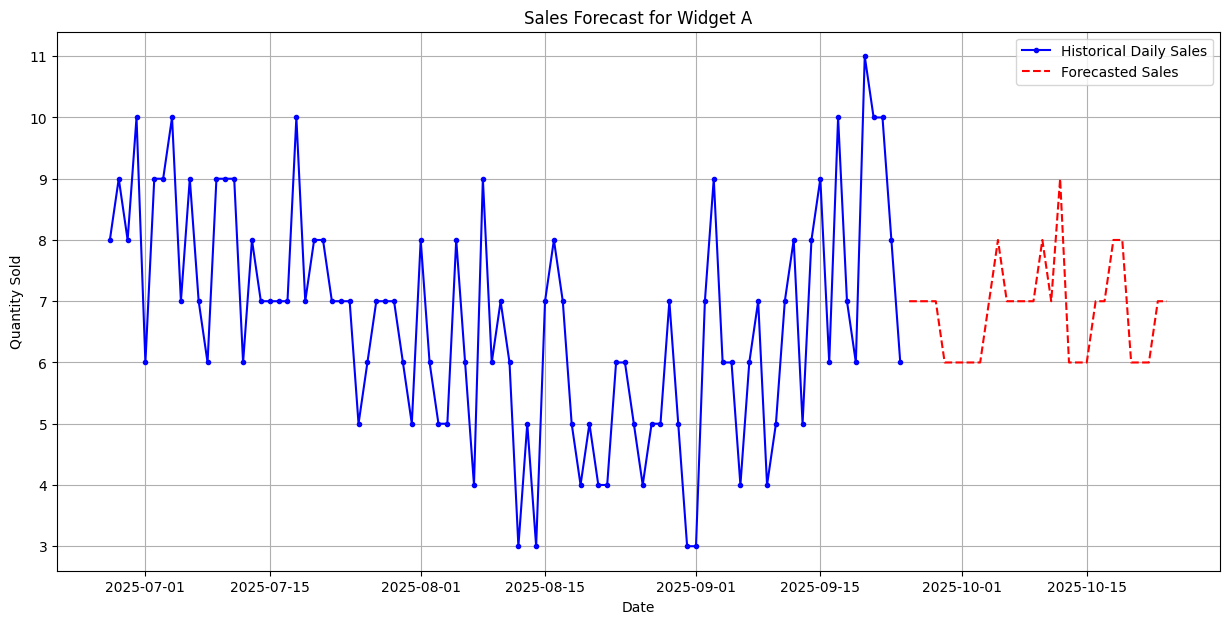

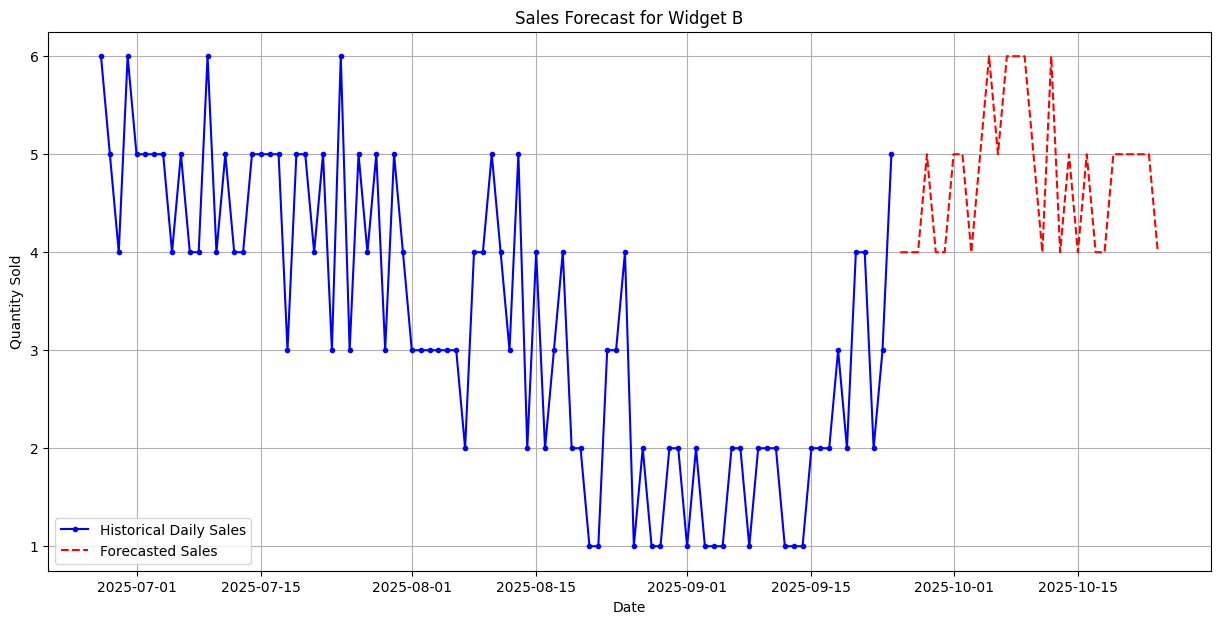

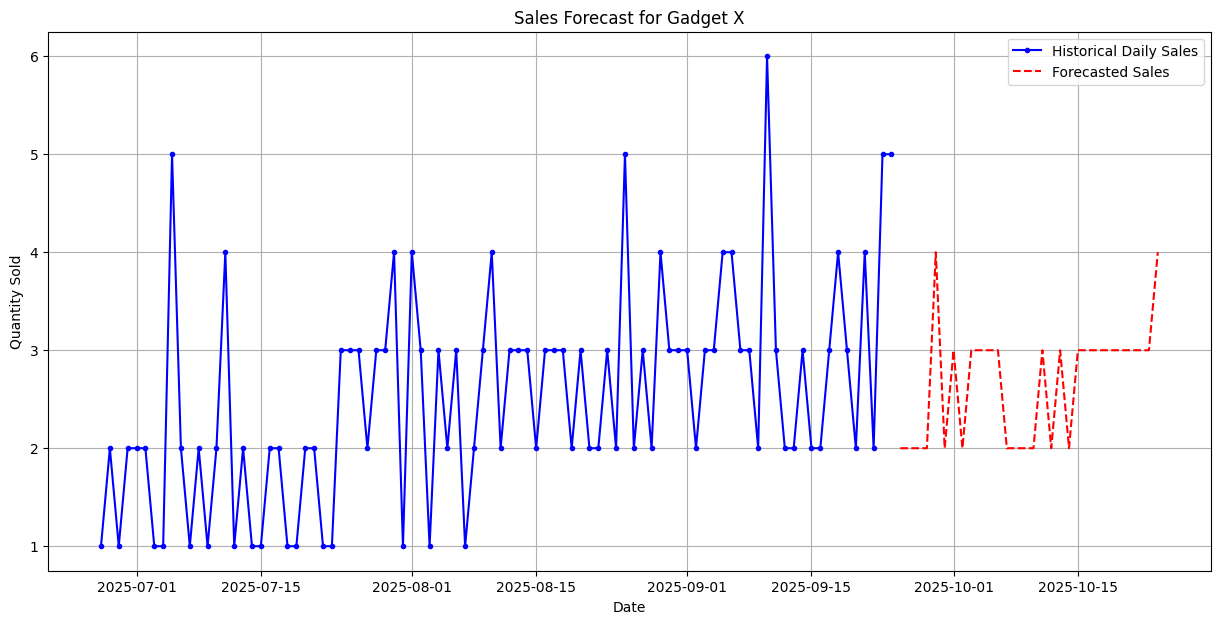

In [13]:
def plot_forecasts(product_name, historical_df, forecast_df):
    """
    Plots historical daily sales and the forecast for a specific product.
    """
    plt.figure(figsize=(15, 7))

    # Get historical data for the specific product
    product_history = historical_df[historical_df['product_name'] == product_name]

    # Plot historical data (last 90 days for clarity)
    plt.plot(product_history['date'].tail(90), product_history['quantity'].tail(90), label='Historical Daily Sales', color='blue', marker='.')

    # Plot forecasted data
    plt.plot(forecast_df['date'], forecast_df['predicted_quantity'], label='Forecasted Sales', color='red', linestyle='--')

    plt.title(f'Sales Forecast for {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the forecasts for each product
for name, forecast in all_predictions.items():
    plot_forecasts(name, daily_sales_featured, forecast)

In [14]:
def get_product_info(product_id, db_path=DB_PATH):
    """Retrieves full product details from the database."""
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute('SELECT name, current_stock, reorder_level FROM products WHERE product_id=?', (product_id,))
    r = cur.fetchone()
    conn.close()
    if r:
        return {'name': r[0], 'current_stock': r[1], 'reorder_level': r[2]}
    return None

print("\n--- Inventory Reorder Suggestions ---")

# Create a mapping from product name to product ID for easy lookup
product_id_map = pd.read_sql('SELECT product_id, name FROM products', sqlite3.connect(DB_PATH)).set_index('name')['product_id'].to_dict()

for name, forecast_df in all_predictions.items():
    product_id = product_id_map[name]
    product_info = get_product_info(product_id)

    # Calculate total predicted demand for the next 30 days
    predicted_demand = forecast_df['predicted_quantity'].sum()

    # Required stock = predicted demand + safety stock (reorder_level)
    required_stock = predicted_demand + product_info['reorder_level']

    current_stock = product_info['current_stock']

    print(f"\nProduct: {name} (ID: {product_id})")
    print(f"  Current Stock: {current_stock}")
    print(f"  Safety Stock (Reorder Level): {product_info['reorder_level']}")
    print(f"  Predicted Demand (Next 30 days): {predicted_demand}")
    print(f"  Required Stock Level (Demand + Safety): {required_stock}")

    if current_stock < required_stock:
        reorder_quantity = required_stock - current_stock
        print(f"  Recommendation: 🚨 LOW STOCK. Order at least {reorder_quantity} units.")
    else:
        print("  Recommendation: ✅ Stock level is sufficient.")


--- Inventory Reorder Suggestions ---

Product: Widget A (ID: 1)
  Current Stock: 497
  Safety Stock (Reorder Level): 50
  Predicted Demand (Next 30 days): 205
  Required Stock Level (Demand + Safety): 255
  Recommendation: ✅ Stock level is sufficient.

Product: Widget B (ID: 2)
  Current Stock: 299
  Safety Stock (Reorder Level): 40
  Predicted Demand (Next 30 days): 143
  Required Stock Level (Demand + Safety): 183
  Recommendation: ✅ Stock level is sufficient.

Product: Gadget X (ID: 3)
  Current Stock: 250
  Safety Stock (Reorder Level): 30
  Predicted Demand (Next 30 days): 80
  Required Stock Level (Demand + Safety): 110
  Recommendation: ✅ Stock level is sufficient.
